In [25]:
from sklearn.datasets import load_sample_image
china=load_sample_image("china.jpg")/255

In [26]:
flower=load_sample_image("flower.jpg")/255

In [27]:
import numpy as np
images=np.array([china,flower])
batch_size, height, width, channels=images.shape


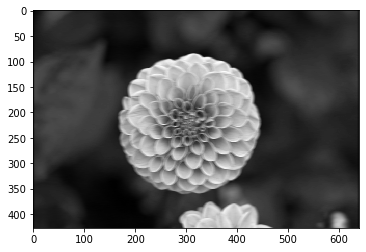

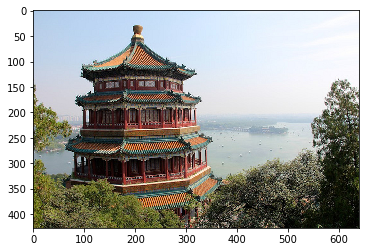

In [28]:
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
filters=np.zeros(shape=(7,7,channels,2),dtype=np.float32)
filters[:, 3, :, 0]=1
filters[3, :, :, 1]=1
outputs=tf.nn.conv2d(images, filters, strides=1, padding='SAME')
plt.imshow(outputs[1,:,:,1],cmap="gray")
plt.show()
plt.imshow(china,cmap="gray")
plt.show()

class ResidualUnit(keras.layers.Layer):

In [37]:
from tensorflow import keras
class ResidualUnit(keras.layers.Layer):
    def __init__(self,filters,strides=1,activation="relu",**kwargs):
        super().__init__(**kwargs)
        self.activation=tf.keras.activations.get(activation)
        self.main_layers=[
            tf.keras.layers.Conv2D(filters,3,strides=strides,padding="same",use_bias=False),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            tf.keras.layers.Conv2D(filters,3,strides=1,padding="same",use_bias=False),
            tf.keras.layers.BatchNormalization()]
        self.skip_layers=[]
        if strides>1:
            skip_layers=[tf.keras.layers.Conv2D(filters,1,strides=strides,padding="same",use_bias=False),tf.keras.layers.BatchNormalization()]
    def call(self,inputs):
        Z=inputs
        for layer in self.main_layers:
            Z=layer(Z)
        skip_Z=inputs
        for layer in self.skip_layers:
            skip_Z=layer(skip_Z)
        return self.activation(Z+skip_Z)
            
        
    

In [39]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(64,7,strides=2,padding="same",use_bias=False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=2,padding="same"))
for _ in range(3):
    model.add(ResidualUnit(filters=64,strides=1))
model.add(ResidualUnit(filters=128,strides=2))
for _ in range(3):
    model.add(ResidualUnit(filters=128,strides=1))
model.add(ResidualUnit(filters=256,strides=2))
for _ in range(5):
    model.add(ResidualUnit(filters=256,strides=1))
model.add(ResidualUnit(filters=512,strides=2))
for _ in range(2):
    model.add(ResidualUnit(filters=512,strides=1))
model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10,activation="softmax"))




In [40]:
model_RES=tf.keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 31s 0us/step


In [41]:
images_resized=tf.image.resize(images,[224,224])
inputs=keras.applications.resnet50.preprocess_input(images_resized*255)

In [43]:
y_prob=model_RES.predict(inputs)

In [45]:
import tensorflow_datasets as tfds
dataset,info=tfds.load("tf_flowers",as_supervised=True,with_infor=True)
dataset_size=info.splits["train"].num_examples
class_names=info.features["label"].names
n_classes=info.features["label"]

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /Users/abdallanimer/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [54]:
train_set,test_set,valid_set=tfds.load("tf_flowers", split=[ 'train[:75%]', 'train[75%:85%]','train[85%:]'],as_supervised=True)


In [56]:
print(train_set)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [58]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label